In [1]:
import os
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLAB = False
KAGGLE = False

In [2]:
COLORS = np.array(
    [
        [0, 0, 0],  # unlabeled    =   0,
        [70, 70, 70],  # building     =   1,
        [190, 153, 153],  # fence        =   2,
        [250, 170, 160],  # other        =   3,
        [220, 20, 60],  # pedestrian   =   4,
        [153, 153, 153],  # pole         =   5,
        [157, 234, 50],  # road line    =   6,
        [128, 64, 128],  # road         =   7,
        [244, 35, 232],  # sidewalk     =   8,
        [107, 142, 35],  # vegetation   =   9,
        [0, 0, 142],  # car          =  10,
        [102, 102, 156],  # wall         =  11,
        [220, 220, 0],  # traffic sign =  12,
        [60, 250, 240],  # anomaly      =  13,
    ]
)

LABEL_NAMES = [
    "unlabeled",
    "building",
    "fence",
    "other",
    "pedestrian",
    "pole",
    "road line",
    "road",
    "sidewalk",
    "vegetation",
    "car",
    "wall",
    "traffic sign",
    "anomaly",
]



def color(annotated_image: np.ndarray, colors: np.ndarray = COLORS) -> Image.Image:
    img_new = np.zeros((*annotated_image.shape, 3), dtype=np.uint8)

    for index, color in enumerate(colors):
        img_new[annotated_image == index] = color

    return Image.fromarray(img_new, "RGB")

In [3]:
if COLAB:
    !wget https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar -O train.tar
    !tar -xf train.tar

## Data Preparation


In [9]:
class StreetHazardDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, image_transform=None, target_transform=None, positive_pairs=False, pixel_per_class=6
    ):
        # Read the JSON file
        with open(annotations_file, "r") as f:
            self.data = json.load(f)

        self.img_dir = img_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        self.positive_pairs = positive_pairs
        self.pixel_per_class = pixel_per_class

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        img_path = os.path.join(self.img_dir, sample["fpath_img"])
        seg_path = os.path.join(self.img_dir, sample["fpath_segm"])

        image = Image.open(img_path).convert("RGB")
        segmentation = Image.open(seg_path)

        if self.image_transform:
            image = self.image_transform(image)

        if self.target_transform:
            segmentation = self.target_transform(segmentation)
            segmentation = torch.as_tensor(np.array(segmentation)) - 1 # -1 to have classes from 0 to 12
        
        if not self.positive_pairs:
            return image, segmentation.long() 
        else:
            """
            For the metric learning task, we need to generate positive pairs (pairs of pixels that belong to the same class).
            We do that in a way that we take the same amount of positive pairs for each class in order to better train the model.
            """
            # Different classes in the segmentation
            classes = torch.unique(segmentation)
            selected_pixels = []
            # Number of pixels to select in total
            N = 13 * self.pixel_per_class
            target_matrix = torch.zeros((N, N), dtype=torch.long)

            # For each class, try to take the same amount of positive pair
            selected_num_pixel_per_class = torch.tensor([min((segmentation == c).sum().item(), self.pixel_per_class) for c in classes])
            num_pixel_per_class = torch.tensor([(segmentation == c).sum().item() for c in classes])
            
            # If a class dont have enough pixel, we need to take more pixel from other classes
            classes_with_not_enough_pixel = classes[selected_num_pixel_per_class < self.pixel_per_class]
            num_pixels_remaining = N - selected_num_pixel_per_class.sum().item()
            
            # Assign the remaining pixels to the classes that have enough pixels
            while num_pixels_remaining > 0:
                for index, c in enumerate(classes):
                    if c not in classes_with_not_enough_pixel and num_pixel_per_class[index] > selected_num_pixel_per_class[index]:
                        selected_num_pixel_per_class[index] += 1
                        num_pixels_remaining -= 1
                        if num_pixels_remaining <= 0:
                            break
                        
            # Build the target tensor
            tot = 0
            for n in selected_num_pixel_per_class:
                n = n.item()
                target_matrix[tot:tot+n, tot:tot+n] = 1 
                tot += n
                
            selected_pixels = torch.tensor([])
                
            for index, c in enumerate(classes):
                flattened_segmentation = segmentation.flatten()
                mask = flattened_segmentation == c
                mask_len = mask.sum().item()
                mask_indexes = torch.arange(len(flattened_segmentation))[mask]
                # Select a random permutation of the indexes
                random_perm = torch.randperm(mask_len)[:selected_num_pixel_per_class[index]]
                selected_indexes = mask_indexes[random_perm]
                # print(f"Selected indexes: {selected_indexes.shape}")
                # selected_pixels.append(selected_indexes)
                selected_pixels = torch.cat((selected_pixels, selected_indexes))
                
            # selected_pixels = torch.stack(selected_pixels)
            # while remaining_pairs > 0:
            #     for c in classes:
            #         flattened_segmentation = segmentation.flatten()
            #         mask = flattened_segmentation == c
            #         mask_len = mask.sum().item()
            #         mask_indexes = torch.arange(len(flattened_segmentation))[mask]
            #         # Select a random permutation of the indexes
            #         random_perm = torch.randperm(mask_len)[:min(mask_len, (self.positive_pairs_size // len(classes)))]
                    
            #         selected_indexes = mask_indexes[random_perm]
            #         pos_pairs_class = torch.combinations(selected_indexes, 2).to(device)
                    
            #         # If we have more pairs than the remaining pairs, we take only the remaining pairs
            #         pos_pairs_class = pos_pairs_class[:min(pos_pairs_class.size(0), remaining_pairs, (self.positive_pairs_size // len(classes)))]
            #         pos_pairs.append(pos_pairs_class)
            #         remaining_pairs -= pos_pairs_class.size(0)
                    
            #         if remaining_pairs <= 0:
            #             break
            
            # pos_pairs = torch.cat(pos_pairs)
            # all_selected_pixels = torch.unique(pos_pairs.flatten())
            # Assign at each different selected pixel an index
            # pixel_to_index = {pixel.item(): index for index, pixel in enumerate(all_selected_pixels)}
            # pos_pairs_relative = torch.tensor([[pixel_to_index[pixel.item()] for pixel in pair] for pair in pos_pairs]) 
            return image, segmentation.long(), (selected_pixels.long(), target_matrix) # (pos_pairs, pos_pairs_relative)

In [10]:
IMAGE_SIZE = (14 * 30, 14 * 30)
BATCH_SIZE = 2
POSITIVE_PAIRS = True
PIXEL_PER_CLASS = 5

# Percorsi dei file
if COLAB:
    annotations_file = "/content/train/train.odgt"
    img_dir = "/content/train"
elif KAGGLE:
    annotations_file = "../input/streethazards-train/train/train.odgt"
    img_dir = "../input/streethazards-train/train"
else:
    annotations_file = "./data/train/train.odgt"
    img_dir = "./data/train"


# Trasformazioni
image_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE, interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE, interpolation=InterpolationMode.NEAREST),
        # transforms.ToTensor(),
    ]
)

# Crea il dataset
dataset = StreetHazardDataset(
    annotations_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=POSITIVE_PAIRS,
    pixel_per_class=PIXEL_PER_CLASS
)

dl = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Classes: tensor([ 0,  2,  5,  6,  7,  9, 11, 12], dtype=torch.uint8)
Classes: tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 12], dtype=torch.uint8)
Image shape: torch.Size([3, 420, 420])
Segmentation shape: torch.Size([420, 420])
Selected pixels: torch.Size([65])
Target matrix: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


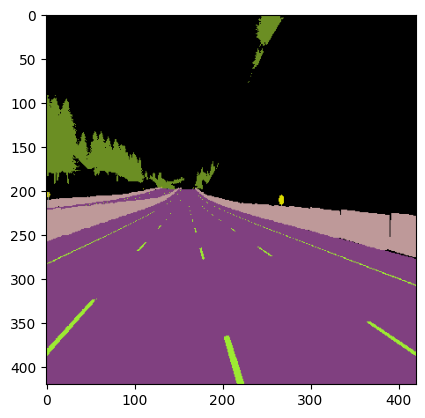

In [11]:
# Show a sample
for image, segmentation, (selected_pixels ,target_matrix) in dl:
        
    print(f"Image shape: {image[0].shape}")
    print(f"Segmentation shape: {segmentation[0].shape}")
    print(f"Selected pixels: {selected_pixels[0].shape}")
    print(f"Target matrix: {target_matrix[0][0]}")
    plt.imshow(color(segmentation[0].cpu().numpy()))
    plt.show()
    break

## Model definition


In [6]:
class DINOv2_SemanticSegmentation(nn.Module):
    def __init__(self, num_classes: int, image_size: Tuple[int, int], fine_grained_features_size: int = 128):
        super().__init__()
        self.num_classes = num_classes

        self.feature_extractor = torch.hub.load(
            "facebookresearch/dinov2", "dinov2_vits14"
        )

        self.head = SegmentationHead(num_classes, d_model=384, image_size=image_size, fine_grained_features_size=fine_grained_features_size)

        self.fine_grained_features_extractor = nn.Sequential(
            nn.Conv2d(3,
                      fine_grained_features_size // 2,
                      kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(fine_grained_features_size // 2),
            nn.Conv2d(fine_grained_features_size // 2,
                      fine_grained_features_size,
                      kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(fine_grained_features_size),
        )

    def forward(self, x):
        y = self.feature_extractor(x, is_training=True)
        backbone_features = y["x_norm_patchtokens"]

        B, HW, d_model = backbone_features.shape
        backbone_features = backbone_features.view(
            (B, int(np.sqrt(HW)), int(np.sqrt(HW)), d_model)
        )
        backbone_features = torch.permute(backbone_features, (0, 3, 1, 2))

        fine_grained_features = self.fine_grained_features_extractor(x)

        return self.head(backbone_features, fine_grained_features)


class SegmentationHead(nn.Module):
    def __init__(self, num_classes: int, d_model: int, image_size: Tuple[int, int], fine_grained_features_size: int = 128):
        """Segmentation Head for DINOv2

        Args:
            num_classes (int): The number of classes to segment (if None, it will output all the features)
            d_model (int): The dimension of the input embeddings from the backbone
            image_size (Tuple[int, int]): The size of the output image
        """
        super().__init__()
        self.num_classes = num_classes

        self.l1 = nn.Linear(d_model, 512)
        self.up = nn.Upsample(image_size)
        if num_classes is not None:
            # Segmentation
            self.out = nn.Conv2d(
                512 + fine_grained_features_size,
                num_classes,
                kernel_size=1,
                stride=1,
                padding="same",
                padding_mode="reflect",
            )
        else:
            # Metric Learning
            self.out = nn.Conv2d(
                512 + fine_grained_features_size,
                512 + fine_grained_features_size,
                kernel_size=3,
                stride=1,
                padding="same",
                padding_mode="reflect",
            )

        # self.out = nn.Sequential(
        #     nn.Conv2d(512, 128, kernel_size=3, stride=1, padding="same"),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Conv2d(128, 64, kernel_size=3, stride=1, padding="same"),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding="same"),
        # )

    def forward(self, backbone_features, fine_grained_features):
        """
            First the backbone features are upsampled to match the image size.
            Then the fine-grained features are concatenated to the backbone features.
            Finally, the output is computed with a Conv2D.
        """
        B, d_model, H, W = backbone_features.shape
        backbone_features = torch.permute(backbone_features, (0, 2, 3, 1))
        # (B, H, W, d_model)

        backbone_features = self.l1(backbone_features)
        # (B, H, W, 512)

        backbone_features = torch.permute(backbone_features, (0, 3, 1, 2))
        # (B, 512, H, W)

        backbone_features = self.up(backbone_features)
        # (B, 512, image_size, image_size)

        # Concatenate fine-grained features
        features = torch.cat((backbone_features, fine_grained_features), dim=1)
        # (B, 512 + fine_grained_features_size, image_size, image_size)

        out = self.out(features)
        # (B, num_classes, image_size, image_size)
        return out

## Semantic Segmentation

In [ ]:
criterion = nn.CrossEntropyLoss()
EPOCHS = 10
LOAD_WEIGHTS = False
LEARNING_RATE = 1e-3

segmentation_model = DINOv2_SemanticSegmentation(
    num_classes=13, image_size=IMAGE_SIZE, fine_grained_features_size=128
).to(device)

if LOAD_WEIGHTS:
    if COLAB:
        path_prefix = "/content/"
    elif KAGGLE:
        path_prefix = "/kaggle/input/"
    else:
        path_prefix = "./"
    path = os.path.join(path_prefix, "segmentation_model.pth")
    segmentation_model.load_state_dict(torch.load("/kaggle/input/segmentation_model.pth"))
        

for param in segmentation_model.feature_extractor.parameters():
    param.requires_grad = False

segmentation_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, segmentation_model.parameters()), lr=LEARNING_RATE
)

for epoch in range(EPOCHS):
    for images, segmentations, _ in tqdm(dl):
        images = images.to(device)
        segmentations = segmentations.to(device)
        
        logits = segmentation_model(images)
        
        loss = criterion(logits, segmentations)
        segmentation_optimizer.zero_grad()
        loss.backward()
        segmentation_optimizer.step()
        
        print(f"Epoch {epoch}/{EPOCHS} - {loss.item()}")

  0%|          | 0/2563 [00:00<?, ?it/s]

Epoch 0/10 - 1.034580945968628
Epoch 0/10 - 0.921288788318634
Epoch 0/10 - 1.1165852546691895


KeyboardInterrupt: 

torch.Size([280, 280])
torch.Size([280, 280])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [7, 7, 7,  ..., 0, 0, 0],
        [7, 7, 7,  ..., 0, 0, 0],
        [7, 7, 7,  ..., 0, 0, 0]])
tensor([[2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        ...,
        [9, 9, 9,  ..., 8, 8, 8],
        [9, 9, 9,  ..., 8, 8, 8],
        [9, 9, 9,  ..., 8, 8, 8]], dtype=torch.uint8)


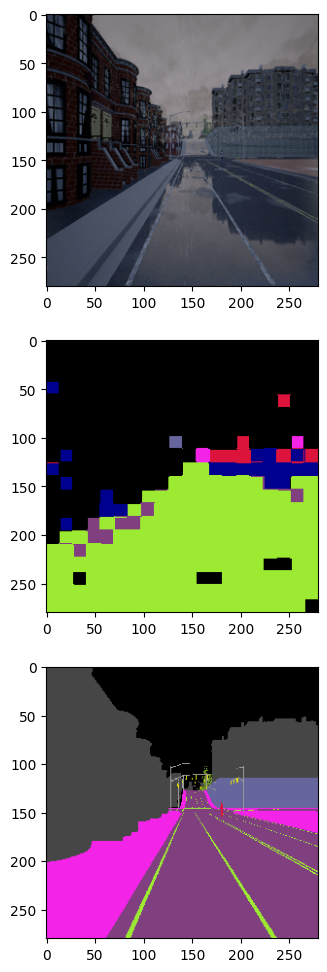

In [ ]:
# Test the trained model
for images, segmentations, _ in dl:
    images = images.to(device)
    segmentations = segmentations.to(device)

    pixel_embeddings = segmentation_model(images)
    # Plot 3 images in the same plot (RGB, predicted, ground truth)
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].imshow(images[0].permute(1, 2, 0).cpu())
    ax[1].imshow(color(pixel_embeddings[0].argmax(dim=0).cpu()))
    ax[2].imshow(color(segmentations[0].cpu()))

    print(pixel_embeddings[0].argmax(dim=0).cpu())
    print(segmentations[0].cpu())
    break

In [ ]:
# Save the segmentation model
torch.save(segmentation_model.state_dict(), "segmentation_model.pth")

## Metric Learning


In [7]:
def batch_nt_bxent_loss(x, target_matrix, temperature, device="cpu"):
    B = x.size(0)
    assert len(x.size()) == 3
    assert x.size(0) == len(target_matrix)

    loss = None
    for i in range(B):
        if loss is None:
            loss = nt_bxent_loss(x[i], target_matrix[i], temperature, device)
        else:
            loss += nt_bxent_loss(x[i], target_matrix[i], temperature, device)

    loss /= B
    return loss


# NT-Xent Loss
def nt_bxent_loss(x, target_matrix, temperature, device="cpu"):
    # pos_indices = pos_indices.to(device)
    x = x.to(device)
    assert len(x.size()) == 2

    # Add indexes of the principal diagonal elements to pos_indices
    # pos_indices = torch.cat(
    #     [
    #         pos_indices,
    #         torch.arange(x.size(0)).reshape(x.size(0), 1).expand(-1, 2).to(device),
    #     ],
    #     dim=0,
    # )

    # Ground truth labels
    # target = torch.zeros(x.size(0), x.size(0)).to(device)
    # target[pos_indices[:, 0], pos_indices[:, 1]] = 1.0
    # target[pos_indices[:, 1], pos_indices[:, 0]] = 1.0

    # Cosine similarity
    xcs = F.cosine_similarity(x[None, :, :], x[:, None, :], dim=-1)
    # Set logit of diagonal element to "inf" signifying complete
    # correlation. sigmoid(inf) = 1.0 so this will work out nicely
    # when computing the Binary cross-entropy Loss.
    xcs[torch.eye(x.size(0)).bool().to(device)] = float("inf")

    # Standard binary cross-entropy loss. We use binary_cross_entropy() here and not
    # binary_cross_entropy_with_logits() because of
    # https://github.com/pytorch/pytorch/issues/102894
    # The method *_with_logits() uses the log-sum-exp-trick, which causes inf and -inf values
    # to result in a NaN result.
    # Convert target matrix to float
    target_matrix = target_matrix.float()
    loss = F.binary_cross_entropy(
        (xcs / temperature).sigmoid(), target_matrix, reduction="none"
    )

    target_pos = target_matrix.bool()
    target_neg = ~target_pos

    loss_pos = (
        torch.zeros(x.size(0), x.size(0))
        .to(device)
        .masked_scatter(target_pos, loss[target_pos])
        .to(device)
    )
    loss_neg = (
        torch.zeros(x.size(0), x.size(0))
        .to(device)
        .masked_scatter(target_neg, loss[target_neg])
        .to(device)
    )
    loss_pos = loss_pos.sum(dim=1)
    loss_neg = loss_neg.sum(dim=1)
    num_pos = target_matrix.sum(dim=1)
    num_neg = x.size(0) - num_pos

    return ((loss_pos / num_pos) + (loss_neg / num_neg)).mean()


def custom_loss(x, selected_pixels, target_matrix, temperature, device="cpu"):
    B, emb_size, H, W = x.shape
    x = x.view(B, emb_size, H * W)
    # B, emb_size, HW = x.shape
    
    
    x = torch.permute(x, (0, 2, 1))
    
    # print(f"Selected pixels: {selected_pixels.shape}")
    # print(f"selected_pixels type: {selected_pixels.dtype}")
    # print(selected_pixels)
    # print("x.shape", x.shape)
    
    x_selected = torch.zeros((B, selected_pixels.shape[1], emb_size), dtype=torch.float32)
    # selected_pixels = torch.unique(pos_pairs.flatten())
    for i in range(B):
        x_selected[i] = x[i, selected_pixels[i], :]
    x = x_selected
    return batch_nt_bxent_loss(x, target_matrix, temperature, device)

In [8]:
from sklearn.decomposition import PCA


def semantic_embeddings_plot(model, dl, num_points: int = 100):
    for images, segmentations, _ in dl:
        image = images[0].to(device)
        segmentation = segmentations[0].to(device)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.show()
        plt.imshow(color(segmentation.cpu()))
        plt.show()

        out = model(image[None, ...])
        # Apply PCA on the channel dimension of the output embeddings
        out = out[0]
        pca = PCA(n_components=2)
        C, H, W = out.shape
        out = torch.permute(out, (1, 2, 0))
        out = out.view(-1, out.size(-1))
        print(out.shape)
        pca_out = pca.fit_transform(out.cpu().detach().numpy())
        pca_out = pca_out.reshape(H, W, 2)
        print(pca_out.shape)

        # Pick 1000 random pixels
        selected_pixels_x = torch.randperm(H)[:num_points]
        selected_pixels_y = torch.randperm(W)[:num_points]
        different_segmentation_values = torch.unique(segmentation)
        
        print(different_segmentation_values)

        for i in range(len(different_segmentation_values)):
            plt.scatter(
                x=pca_out[selected_pixels_x, selected_pixels_y][
                    segmentation[selected_pixels_x, selected_pixels_y]
                    == different_segmentation_values[i].item(),
                    0,
                ],
                y=pca_out[selected_pixels_x, selected_pixels_y][
                    segmentation[selected_pixels_x, selected_pixels_y]
                    == different_segmentation_values[i].item(),
                    1,
                ],
                label=different_segmentation_values[i].item(),
            )
        plt.legend()
        plt.show()
        break

In [9]:
x = torch.tensor([[[1,1,-5,-5], [1,1,-5,-5], [1,1,-5,-5]]])
# (B, num_pixels, emb_size)
selected_pixels = torch.tensor([[0, 1, 2, 3]])

target_matrix = torch.tensor([[[1, 1, 0, 0],
                              [1, 1, 0, 0],
                              [0, 0, 1, 1],
                              [0, 0, 1, 1]]])
print("x.shape",x.shape)
print("selected_pixels.shape", selected_pixels.shape)
print("target_matrix.shape", target_matrix.shape)
loss = custom_loss(x, selected_pixels, target_matrix=target_matrix, temperature=0.1)
print(loss)

x.shape torch.Size([1, 3, 4])
selected_pixels.shape torch.Size([1, 4])
target_matrix.shape torch.Size([1, 4, 4])


ValueError: not enough values to unpack (expected 4, got 3)

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


0it [00:00, ?it/s]

Epoch 0/10 - 0.7808535099029541


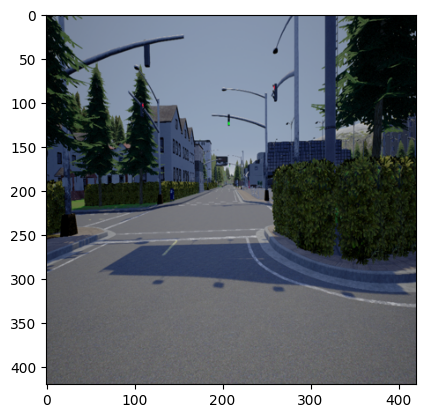

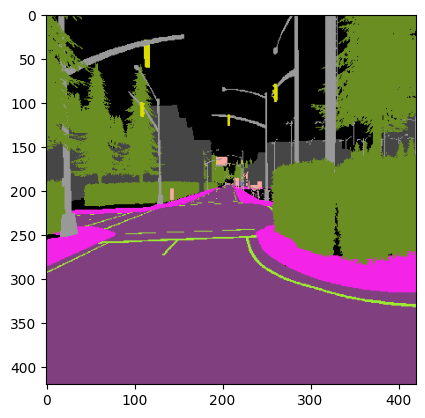

torch.Size([176400, 640])
(420, 420, 2)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12])


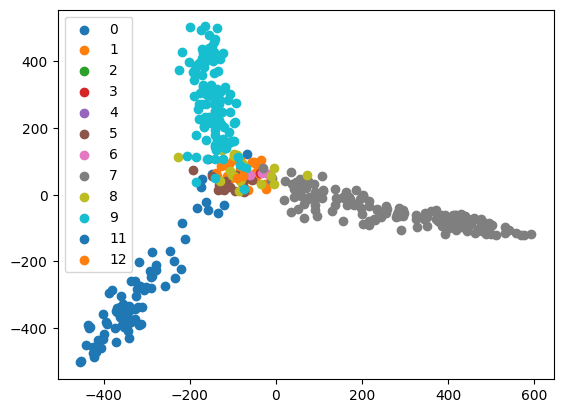

KeyboardInterrupt: 

In [10]:
EPOCHS = 10
TEMPERATURE = 0.1
LEARNING_RATE = 5e-4
LOAD_WEIGHTS = True

metric_learning_model = DINOv2_SemanticSegmentation(
    num_classes=None, image_size=IMAGE_SIZE, fine_grained_features_size=128
).to(device)

if LOAD_WEIGHTS:
    if COLAB:
        path_prefix = "/content/drive/"
    elif KAGGLE:
        path_prefix = "/kaggle/working/"
    else:
        path_prefix = "./"
    path = os.path.join(path_prefix, "metric_learning_model2.pth")

    metric_learning_model.load_state_dict(torch.load(path, map_location=device))

for param in metric_learning_model.feature_extractor.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, metric_learning_model.parameters()),
    lr=LEARNING_RATE,
)


for epoch in range(EPOCHS):
    for index, (images, segmentations, (selected_pixels, target_matrix)) in tqdm(enumerate(dl)):
        images = images.to(device)
        segmentations = segmentations.to(device)
        
        # Compute the pixel embeddings        
        pixel_embeddings = metric_learning_model(images).to(device)

        # Compute the metric learning loss
        loss = custom_loss(
            pixel_embeddings, selected_pixels, target_matrix, TEMPERATURE, device=device
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{EPOCHS} - {loss.item()}")

        if index % 200 == 0:
            semantic_embeddings_plot(metric_learning_model, dl, num_points=1000)

In [197]:
x = torch.rand(2, 17640, 640)
selected_pixels = torch.arange(65 * 2).view(2, 65)
print(selected_pixels)
x_selected = torch.zeros(2, 65, 640)
for i in range(2):
    x_selected[i] = x[i, selected_pixels[i], :]
    
print(x_selected.shape)

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64],
        [ 65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
          79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
          93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
         107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
         121, 122, 123, 124, 125, 126, 127, 128, 129]])
torch.Size([2, 65, 640])


In [ ]:
if COLAB:
    !wget https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar -O test.tar
    !tar -xf test.tar

In [11]:
# Load test dataset
if COLAB:
    annotations_file = "/content/test/test.odgt"
    img_dir = "/content/test"
elif KAGGLE:
    annotations_file = "/kaggle/input/test/test.odgt"
    img_dir = "/kaggle/input/test"
else:
    annotations_file = "./data/test/test.odgt"
    img_dir = "./data/test"

test_dataset = StreetHazardDataset(
    annotations_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=True,
    pixel_per_class=40
)

test_dl = DataLoader(test_dataset, batch_size=1, shuffle=True)

Classes: tensor([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=torch.uint8)
torch.Size([1, 3, 280, 280]) torch.Size([1, 280, 280]) torch.Size([1, 40, 2])
(280, 280)


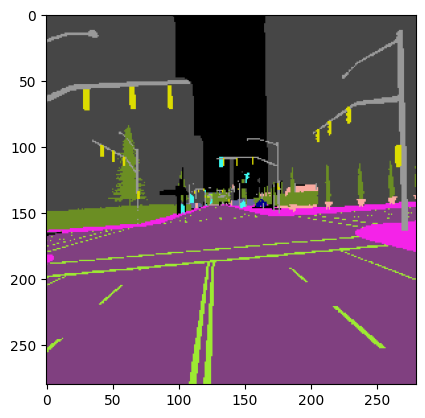

In [212]:
for images, segmentations, (pos_pairs, pos_pairs_relative) in test_dl:
    print(images.size(), segmentations.size(), pos_pairs.size())
    
    segmentations = segmentations[0].cpu().numpy()
    pos_pairs = pos_pairs[0].cpu().numpy()
    
    plt.imshow(color(segmentations))
    break
    
    # print(segmentations.shape, pos_pairs.shape)
    
    # for i in pos_pairs:
    #     print(segmentations[i[0]], segmentations[i[1]])
    # break

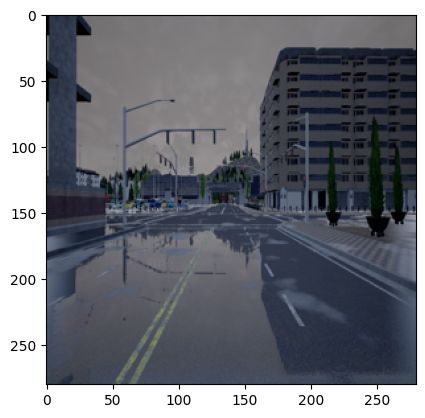

torch.Size([280, 280])


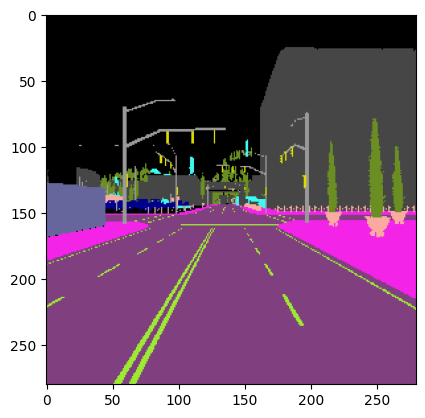

torch.Size([78400, 640])
(280, 280, 2)
tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=torch.uint8)


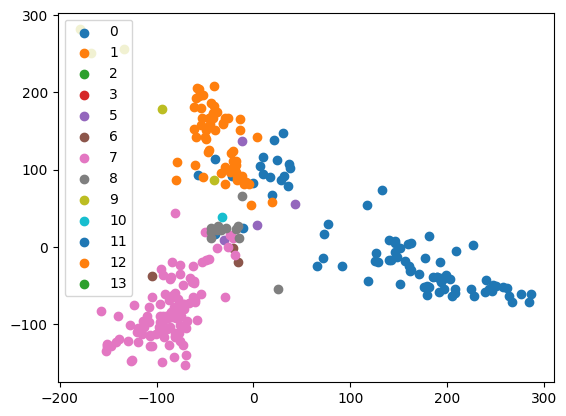

In [12]:
semantic_embeddings_plot(metric_learning_model, test_dl, num_points=100000)

In [40]:
import torch, gc
import os

gc.collect()
torch.cuda.empty_cache()

In [195]:
# Save the model
# torch.save(metric_learning_model.state_dict(), "model.pth")

# metric_learning_model = torch.load("./model2.pth", map_location=torch.device('cpu'))
# Load the state dict model
metric_learning_model = DINOv2_SemanticSegmentation(num_classes=None, image_size=IMAGE_SIZE, fine_grained_features_size=128)
metric_learning_model.load_state_dict(torch.load("model2.pth", map_location=torch.device('cpu')))

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main


<All keys matched successfully>

## Idea for outlier detection

- For each segmentation class, calculate its distribution (Gaussian assumption, so just calculate mean and variance).
- With this pre-calculated distributions, we can calculate, for each pixel, the probability of it belonging to a certain class. If the $\max$ of these probabilities is low, we can classify that pixel as outlier (rely on threshold).

In [42]:
from tqdm.auto import tqdm
def calculate_distribution_for_each_class(metric_learning_model, dl, num:int = 100):
    res = {}
    count = 0
    for images, segmentations, _ in tqdm(dl, total=num // 4):
        count += len(images)
        images = images.to(device)
        segmentations = segmentations.to(device)
        unique_classes = torch.unique(segmentations)
        
        # Calculate the embedding for each pixel
        pixel_embeddings = metric_learning_model(images)
        
        B = len(images)
        for i in range(B):
            # For each class, calculate the mean of the embeddings
            for c in unique_classes:
                mask = segmentations[i] == c
                
                # print("mask", mask.shape)
                # print("pixel_embeddings", pixel_embeddings[i].shape)
                # print("images", images[i].shape)
                # print("segmentations", segmentations[i].shape)
                c = c.item()
                if mask.sum() > 1:
                    if c not in res:
                        # print("AAAAAA", pixel_embeddings[i][:, mask].shape)
                        res[c] = {"mean": pixel_embeddings[i][:, mask].mean(dim=(1)).cpu().detach().numpy(),
                                "std": pixel_embeddings[i][:, mask].std(dim=(1)).cpu().detach().numpy(),
                                "count": mask.sum().cpu().detach().numpy(),}
                        
                        # print("res[c]['mean']", res[c]["mean"].shape)
                        # print("res[c]['std']", res[c]["std"].shape)
                        # print("res[c]['count']", res[c]["count"])
                    else:
                        res[c]["mean"] = (res[c]["mean"] * res[c]["count"] + pixel_embeddings[i][:, mask].sum(dim=(1)).cpu().detach().numpy()) / (res[c]["count"] + mask.sum().cpu().detach().numpy())
                        res[c]["std"] = (res[c]["std"] * res[c]["count"] + pixel_embeddings[i][:, mask].std(dim=(1)).cpu().detach().numpy()) / (res[c]["count"] + mask.sum().cpu().detach().numpy())
                        # res[c][]
                        res[c]["count"] += mask.sum().cpu().detach().numpy()
        print(count)
        if count > num:
            break
    return res

def multivariate_pdf(x, means, cov_matrix):
    d = len(means)
    return np.exp(-0.5 * (x - means).T @ np.linalg.inv(cov_matrix) @ (x - means)) / np.sqrt(np.linalg.det(cov_matrix) * (2 * np.pi) ** d)

# class_std_inv_cache = {}
def probability_belong_to_class(pixel_embedding, class_mean, class_std):
    # if tuple(class_std) not in class_std_inv_cache:
    #     class_std_inv_cache[tuple(class_std)] = np.linalg.inv(np.diag(class_std))
    #     # class_std_inv_cache[tuple(class_std)] = np.diag(class_std)
        
        
    # class_std_inv = class_std_inv_cache[tuple(class_std)]
    # print("x-m",(pixel_embedding - class_mean))
    # print("class_std_inv", class_std_inv)
    # print("prod", (pixel_embedding - class_mean).T @ class_std_inv)
    # print("final prod", (pixel_embedding - class_mean).T @ class_std_inv @ (pixel_embedding - class_mean))
    # print((pixel_embedding - class_mean).T @ class_std_inv @ (pixel_embedding - class_mean))
    # return 1 / np.exp(np.linalg.norm((pixel_embedding - class_mean) * class_std))
    # print(pixel_embedding.shape)
    # print(class_mean.shape)
    return F.cosine_similarity(torch.tensor(pixel_embedding), torch.tensor(class_mean), dim=0)
    # return np.exp(-1 * np.linalg.norm((pixel_embedding - class_mean) / (class_std * 640)))
    # return multivariate_pdf(pixel_embedding, class_mean, class_std) / multivariate_pdf(class_mean, class_mean, class_std)

def classify_new_pixel(pixel_embedding, class_distributions):
    res = {}
    for c in class_distributions:
        m = class_distributions[c]["mean"]
        s = class_distributions[c]["std"]
        res[c] = probability_belong_to_class(pixel_embedding, m, s)
    return res   

In [15]:
import numpy as np
distributions = calculate_distribution_for_each_class(metric_learning_model, dl, num=25)

  0%|          | 0/6 [00:00<?, ?it/s]

2
4
6
8
10
12
14
16
18
20
22
24
26


In [16]:
distributions[1]

{'mean': array([-1.28848556e+01, -1.39173999e+00, -5.82056893e+00, -7.82746948e+00,
        -6.06717437e-01, -3.33616433e+00,  2.70623948e+00, -5.54554516e+00,
         4.50143465e+00, -1.09708894e+01, -7.40651982e+00,  8.56186059e+00,
         3.02982212e+00, -5.66514391e+00,  1.48308523e+00, -1.90750829e+01,
        -2.64786807e+00,  6.26889707e-01, -2.34330016e+00, -2.95623179e+00,
        -1.43460076e+01, -1.33465107e+00,  2.39465724e+00,  1.81830593e+00,
        -5.40981560e+00,  4.78200907e-01,  9.23159128e+00,  4.92697980e+00,
        -2.78809913e+00,  1.61455379e+00,  6.44588187e+00,  5.42258674e+00,
        -3.03920540e+00,  4.35238040e+00,  1.64950711e-02,  3.51803657e+00,
         1.27389051e+00,  7.83542118e+00,  3.51437951e+00,  1.04841213e+01,
         7.10800386e+00,  1.23138537e-01, -5.49036921e+00, -8.30391020e+00,
         1.32523555e+00,  7.11631489e+00,  3.48020550e+00,  2.40563382e+00,
        -1.11267274e+00, -1.19124954e+01,  1.46620264e+00, -6.79989770e-01,
    

In [43]:
# For each class, print the probability distribution of the pixel belonging to that class (expected to be close to 1)
results = {}
for images, segmentations, _ in dl:
    images = images.to(device)
    segmentations = segmentations.to(device)
    pixel_embeddings = metric_learning_model(images)
    pixel_embeddings = pixel_embeddings.view(pixel_embeddings.size(0),pixel_embeddings.size(1), -1)
    segmentations = segmentations.view(segmentations.size(0), -1)
    
    B = len(images)
    for i in range(B):
        # print(pixel_embeddings[i].shape, pixel_embeddings[i].size(0))
        # pixel_embeddings[i] = pixel_embeddings[i].view(pixel_embeddings[i].size(0), -1)
        for c in tqdm(torch.unique(segmentations[i])):
            mask = segmentations[i] == c
            mask_len = mask.sum()
            masked_pixel_embeddings = pixel_embeddings[i][:, mask]
            # for j in tqdm(range(mask_len)):
            for j in tqdm(range(min(100, mask_len))):
                p = masked_pixel_embeddings[:, j].detach().cpu().numpy()
                # print(p.shape)
                # prob = classify_new_pixel(p, distributions)
                # print(p)
                # print(distributions[c.item()]["mean"])
                # if c.item() not in results:
                #     results[c.item()] = {}
                # print(np.linalg.norm((p - distributions[c.item()]["mean"]) / distributions[c.item()]["std"]) / 640)
                prob = probability_belong_to_class(p, distributions[c.item()]["mean"], distributions[c.item()]["std"])
                # Calculate the distance between the pixel embedding and the mean of each class (considering the variance)
                # for other_c in torch.unique(segmentations[i]):
                #     if other_c.item() not in results[c.item()]:
                #         results[c.item()][other_c.item()] = []
                #     other_c = other_c.item()
                #     prob = np.linalg.norm((p - distributions[other_c]["mean"]) / np.sqrt(distributions[other_c]["std"])) / 640
                #     results[c.item()][other_c].append(prob)
                # print(prob)
                # break
            # break
        
                if c.item() not in results:
                    results[c.item()] = []
                    
                results[c.item()].append(prob)            
                
            # for j in range(len(images[i, :, mask])):
            #     pixel_embedding = pixel_embeddings[i][:, j]
            #     print(pixel_embedding.shape)
            #     prob = probability_belong_to_class(pixel_embedding,
            #                                        distributions[c.item()]["mean"],
            #                                        np.diag(distributions[c.item()]["std"].detach().cpu().numpy()))
                
            #     if c.item() not in results:
            #         results[c.item()] = []
                
            #     results[c.item()].append(prob)
    break

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
for c in results:
    print(f"Class {c}")
    for other_c in results[c]:
        print(f"    Class {other_c} - {np.mean(results[c][other_c])}")

Class 0


TypeError: only integer tensors of a single element can be converted to an index

<BarContainer object of 13 artists>

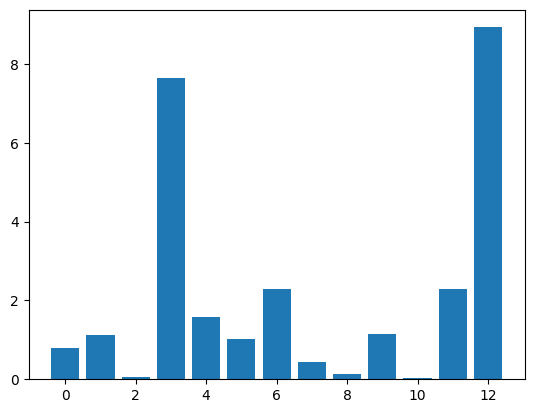

In [44]:
plt.bar(x=[i for i in distributions.keys()], height=[distributions[i]["std"].mean() for i in distributions.keys()])

[tensor(0.1537, dtype=torch.float64), tensor(0.2179, dtype=torch.float64), tensor(0.2806, dtype=torch.float64), tensor(0.2736, dtype=torch.float64), tensor(0.2607, dtype=torch.float64), tensor(0.2560, dtype=torch.float64), tensor(0.2523, dtype=torch.float64), tensor(0.2527, dtype=torch.float64), tensor(0.2579, dtype=torch.float64), tensor(0.2615, dtype=torch.float64), tensor(0.2586, dtype=torch.float64), tensor(0.2554, dtype=torch.float64), tensor(0.2534, dtype=torch.float64), tensor(0.2560, dtype=torch.float64), tensor(0.2560, dtype=torch.float64), tensor(0.2576, dtype=torch.float64), tensor(0.2600, dtype=torch.float64), tensor(0.2646, dtype=torch.float64), tensor(0.2871, dtype=torch.float64), tensor(0.2954, dtype=torch.float64), tensor(0.2953, dtype=torch.float64), tensor(0.2949, dtype=torch.float64), tensor(0.2906, dtype=torch.float64), tensor(0.2851, dtype=torch.float64), tensor(0.2781, dtype=torch.float64), tensor(0.2785, dtype=torch.float64), tensor(0.2803, dtype=torch.float64), 

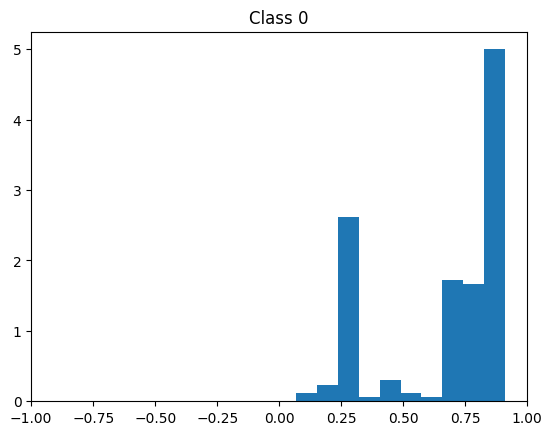

[tensor(0.1227, dtype=torch.float64), tensor(0.1180, dtype=torch.float64), tensor(0.1170, dtype=torch.float64), tensor(0.1163, dtype=torch.float64), tensor(0.1095, dtype=torch.float64), tensor(0.0968, dtype=torch.float64), tensor(0.0827, dtype=torch.float64), tensor(0.1421, dtype=torch.float64), tensor(0.1197, dtype=torch.float64), tensor(0.0311, dtype=torch.float64), tensor(0.0852, dtype=torch.float64), tensor(0.0822, dtype=torch.float64), tensor(0.0439, dtype=torch.float64), tensor(0.0676, dtype=torch.float64), tensor(0.1945, dtype=torch.float64), tensor(0.2150, dtype=torch.float64), tensor(0.2427, dtype=torch.float64), tensor(0.0061, dtype=torch.float64), tensor(0.2017, dtype=torch.float64), tensor(0.2795, dtype=torch.float64), tensor(0.3110, dtype=torch.float64), tensor(0.3161, dtype=torch.float64), tensor(0.2955, dtype=torch.float64), tensor(0.2811, dtype=torch.float64), tensor(0.2741, dtype=torch.float64), tensor(0.3609, dtype=torch.float64), tensor(0.3814, dtype=torch.float64), 

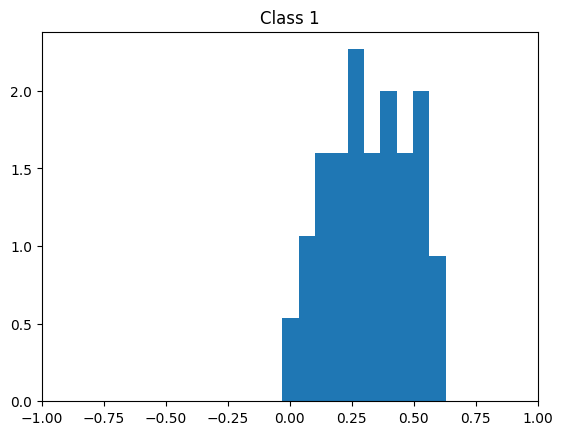

[tensor(-0.0009), tensor(0.0091), tensor(-0.0232), tensor(-0.0057), tensor(-0.0161), tensor(-0.0236), tensor(-0.0140), tensor(-0.0293), tensor(-0.0215), tensor(-0.0715), tensor(-0.0523), tensor(-0.0788), tensor(-0.1220), tensor(-0.0166), tensor(-0.0129), tensor(-0.0095), tensor(-0.0354), tensor(-0.0004), tensor(0.0244), tensor(0.0363), tensor(0.0635), tensor(0.0692), tensor(0.0416), tensor(0.0168), tensor(0.0504), tensor(-0.0229), tensor(-0.0197), tensor(0.0216), tensor(0.0917), tensor(0.1308), tensor(0.1326), tensor(0.1265), tensor(0.1853), tensor(0.2187), tensor(0.2673), tensor(0.1513), tensor(0.1388), tensor(0.0857), tensor(0.1033), tensor(0.0496), tensor(0.0673), tensor(0.0704), tensor(0.1226), tensor(0.1060), tensor(0.1104), tensor(0.0665), tensor(0.0095), tensor(0.0433), tensor(0.0981), tensor(0.1246), tensor(0.1289), tensor(0.1480), tensor(0.1568), tensor(0.1788), tensor(0.2011), tensor(0.2032), tensor(0.1425), tensor(0.1144), tensor(0.0660), tensor(-0.0105), tensor(-0.0346), te

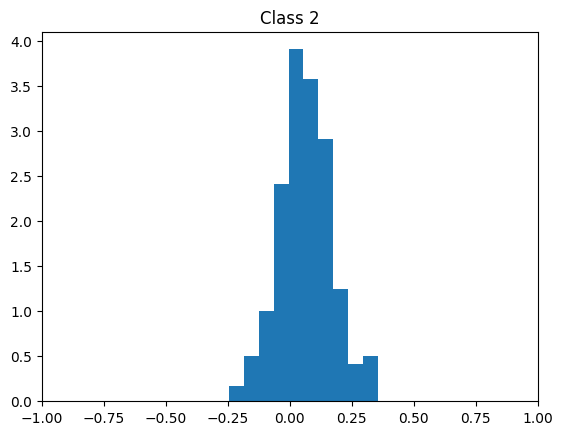

[tensor(0.2830), tensor(0.3668), tensor(0.4453), tensor(0.5437), tensor(0.5426), tensor(0.5058), tensor(0.4985)]


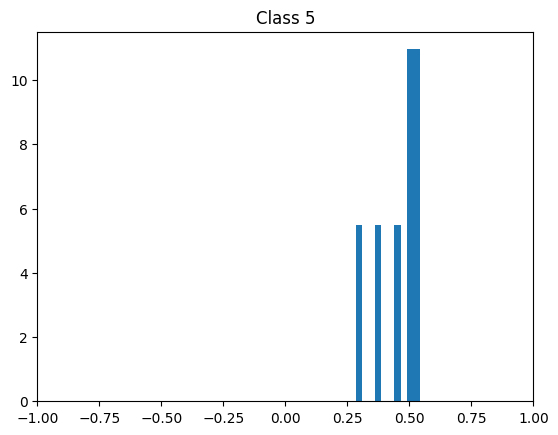

[tensor(-0.0833), tensor(-0.0942), tensor(-0.0706), tensor(-0.0647), tensor(-0.0628), tensor(-0.0655), tensor(-0.0828), tensor(-0.0775), tensor(-0.0682), tensor(-0.0627), tensor(-0.0720), tensor(-0.0724), tensor(-0.0703), tensor(-0.0974), tensor(-0.1111), tensor(-0.1234), tensor(-0.1150), tensor(-0.1154), tensor(-0.1218), tensor(-0.1251), tensor(-0.1241), tensor(-0.1132), tensor(-0.0980), tensor(-0.1020), tensor(-0.1138), tensor(-0.1142), tensor(-0.1106), tensor(-0.1117), tensor(-0.1136), tensor(-0.1045), tensor(-0.0981), tensor(-0.1024), tensor(-0.1029), tensor(-0.0960), tensor(-0.0966), tensor(-0.0977), tensor(-0.0969), tensor(-0.0978), tensor(-0.1007), tensor(-0.1020), tensor(-0.1019), tensor(-0.1104), tensor(-0.1129), tensor(-0.1124), tensor(-0.1123), tensor(-0.1163), tensor(-0.1109), tensor(-0.1124), tensor(-0.1172), tensor(-0.1219), tensor(-0.1222), tensor(-0.1208), tensor(-0.1222), tensor(-0.1164), tensor(-0.1095), tensor(-0.0931), tensor(-0.0841), tensor(-0.0535), tensor(-0.061

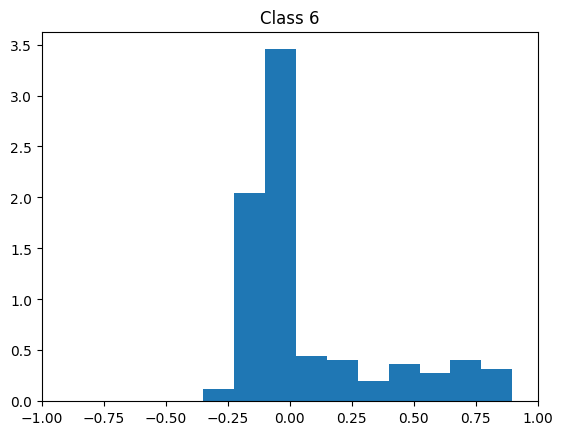

[tensor(0.2080, dtype=torch.float64), tensor(0.1770, dtype=torch.float64), tensor(0.1722, dtype=torch.float64), tensor(0.1323, dtype=torch.float64), tensor(0.1005, dtype=torch.float64), tensor(0.0562, dtype=torch.float64), tensor(0.0624, dtype=torch.float64), tensor(0.0720, dtype=torch.float64), tensor(0.0855, dtype=torch.float64), tensor(0.1104, dtype=torch.float64), tensor(0.1708, dtype=torch.float64), tensor(0.2121, dtype=torch.float64), tensor(0.2225, dtype=torch.float64), tensor(0.2272, dtype=torch.float64), tensor(0.2242, dtype=torch.float64), tensor(0.1786, dtype=torch.float64), tensor(0.1250, dtype=torch.float64), tensor(0.2074, dtype=torch.float64), tensor(0.2226, dtype=torch.float64), tensor(0.2907, dtype=torch.float64), tensor(0.3417, dtype=torch.float64), tensor(0.3849, dtype=torch.float64), tensor(0.3410, dtype=torch.float64), tensor(0.3317, dtype=torch.float64), tensor(0.3228, dtype=torch.float64), tensor(0.2693, dtype=torch.float64), tensor(0.2311, dtype=torch.float64), 

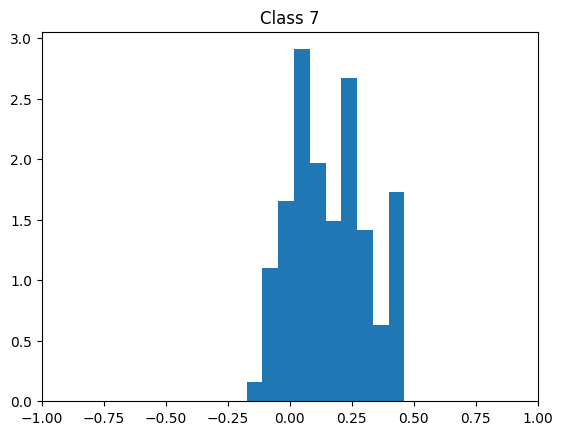

[tensor(0.3289, dtype=torch.float64), tensor(0.3682, dtype=torch.float64), tensor(0.3072, dtype=torch.float64), tensor(0.2657, dtype=torch.float64), tensor(0.2722, dtype=torch.float64), tensor(0.2031, dtype=torch.float64), tensor(0.2143, dtype=torch.float64), tensor(0.0552, dtype=torch.float64), tensor(0.2822, dtype=torch.float64), tensor(0.3111, dtype=torch.float64), tensor(0.3091, dtype=torch.float64), tensor(0.1967, dtype=torch.float64), tensor(0.0975, dtype=torch.float64), tensor(0.1556, dtype=torch.float64), tensor(0.2498, dtype=torch.float64), tensor(0.2369, dtype=torch.float64), tensor(0.1708, dtype=torch.float64), tensor(0.1677, dtype=torch.float64), tensor(0.2385, dtype=torch.float64), tensor(0.2431, dtype=torch.float64), tensor(0.2436, dtype=torch.float64), tensor(0.3094, dtype=torch.float64), tensor(0.3495, dtype=torch.float64), tensor(0.4226, dtype=torch.float64), tensor(0.3578, dtype=torch.float64), tensor(0.3725, dtype=torch.float64), tensor(0.5208, dtype=torch.float64), 

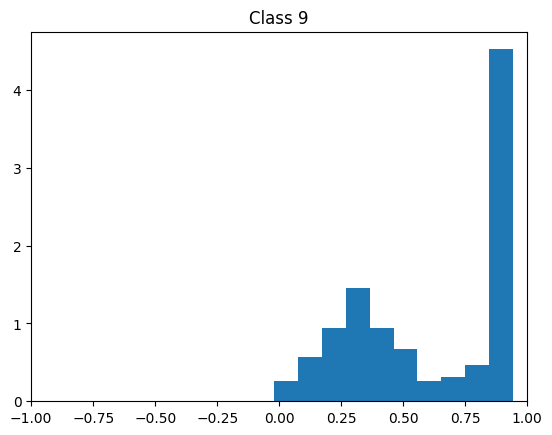

[tensor(0.0584, dtype=torch.float64), tensor(0.0893, dtype=torch.float64), tensor(0.0645, dtype=torch.float64), tensor(0.0253, dtype=torch.float64), tensor(0.1267, dtype=torch.float64), tensor(0.1202, dtype=torch.float64), tensor(0.0379, dtype=torch.float64), tensor(0.0584, dtype=torch.float64), tensor(0.1598, dtype=torch.float64), tensor(0.0757, dtype=torch.float64), tensor(0.0086, dtype=torch.float64), tensor(0.1117, dtype=torch.float64), tensor(0.0905, dtype=torch.float64), tensor(0.1706, dtype=torch.float64), tensor(0.0680, dtype=torch.float64), tensor(0.0372, dtype=torch.float64), tensor(0.0712, dtype=torch.float64), tensor(0.1618, dtype=torch.float64), tensor(0.1308, dtype=torch.float64), tensor(0.1939, dtype=torch.float64), tensor(0.0846, dtype=torch.float64), tensor(0.0787, dtype=torch.float64), tensor(0.0931, dtype=torch.float64), tensor(0.1353, dtype=torch.float64), tensor(0.1821, dtype=torch.float64), tensor(0.1636, dtype=torch.float64), tensor(0.2126, dtype=torch.float64), 

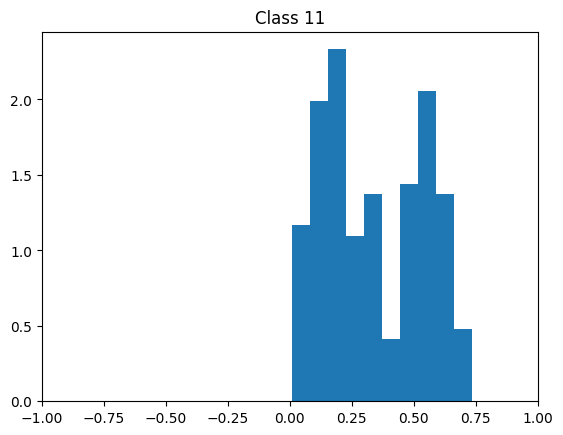

[tensor(0.4981), tensor(0.5729), tensor(0.6245), tensor(0.5005), tensor(0.5428), tensor(0.5818), tensor(0.5115), tensor(0.2431), tensor(0.2400)]


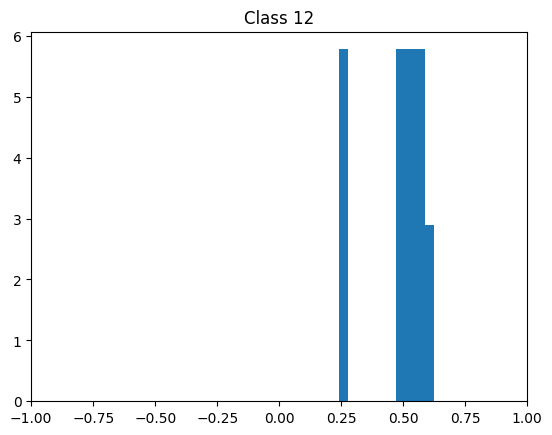

[tensor(0.1095), tensor(0.1954), tensor(0.1798), tensor(0.2110), tensor(0.1943), tensor(0.2290), tensor(0.2508), tensor(0.2632), tensor(0.2461), tensor(0.2356), tensor(0.1833), tensor(0.2366), tensor(0.2590), tensor(0.2782), tensor(0.2685), tensor(0.2482), tensor(0.2136), tensor(0.2060), tensor(0.1863), tensor(0.2059), tensor(0.2334), tensor(0.2460), tensor(0.2433), tensor(0.2263), tensor(0.2293), tensor(0.2166), tensor(0.2112), tensor(0.1948), tensor(0.1945), tensor(0.1226), tensor(0.1974), tensor(0.2330), tensor(0.2539), tensor(0.2623), tensor(0.2434), tensor(0.2267), tensor(0.2122), tensor(0.2080), tensor(0.2166), tensor(0.2056), tensor(0.2042), tensor(0.1937), tensor(0.1987), tensor(0.1187), tensor(0.1804), tensor(0.2555), tensor(0.2497), tensor(0.2375), tensor(0.2209), tensor(0.2048), tensor(0.1987), tensor(0.1971), tensor(0.1987), tensor(0.2127), tensor(0.2081), tensor(0.2070), tensor(0.2038), tensor(0.2129), tensor(0.0509), tensor(0.0713), tensor(0.0783), tensor(0.1527), tensor(

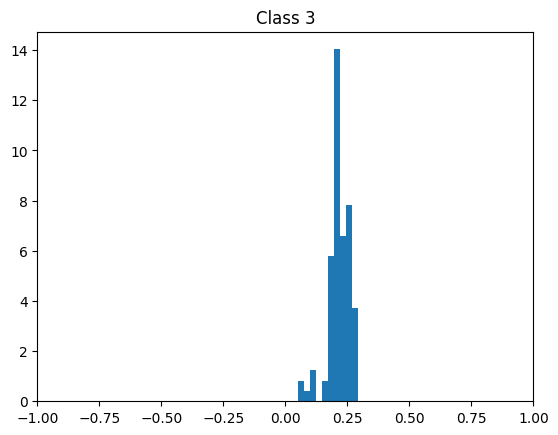

[tensor(0.2111), tensor(0.2238), tensor(0.3106), tensor(0.1888), tensor(0.3510), tensor(0.1827), tensor(0.2435), tensor(0.3165), tensor(0.2951), tensor(0.3560), tensor(0.4001), tensor(0.3266), tensor(0.4467), tensor(0.4250), tensor(0.3303), tensor(0.2773), tensor(0.1353)]


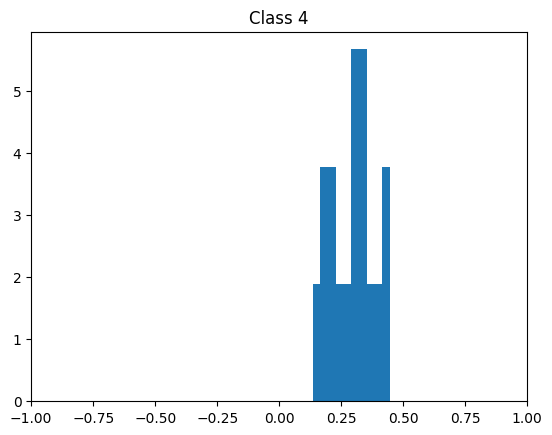

[tensor(-0.0533, dtype=torch.float64), tensor(-0.0256, dtype=torch.float64), tensor(0.0685, dtype=torch.float64), tensor(0.0462, dtype=torch.float64), tensor(-0.0190, dtype=torch.float64), tensor(-0.0208, dtype=torch.float64), tensor(0.0424, dtype=torch.float64), tensor(0.0650, dtype=torch.float64), tensor(0.1012, dtype=torch.float64), tensor(0.0685, dtype=torch.float64), tensor(0.0731, dtype=torch.float64), tensor(0.0937, dtype=torch.float64), tensor(0.1650, dtype=torch.float64), tensor(0.1653, dtype=torch.float64), tensor(0.1855, dtype=torch.float64), tensor(0.1812, dtype=torch.float64), tensor(0.2284, dtype=torch.float64), tensor(0.1970, dtype=torch.float64), tensor(-0.0143, dtype=torch.float64), tensor(-0.1348, dtype=torch.float64), tensor(-0.0970, dtype=torch.float64), tensor(-0.0379, dtype=torch.float64), tensor(0.0976, dtype=torch.float64), tensor(0.1836, dtype=torch.float64), tensor(0.1604, dtype=torch.float64), tensor(0.1015, dtype=torch.float64), tensor(0.0167, dtype=torch.fl

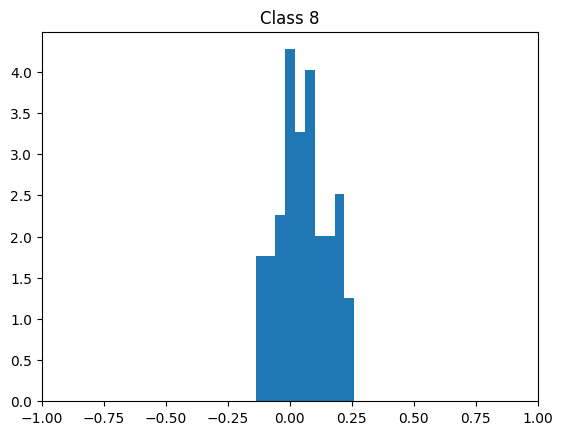

[tensor(-0.0022), tensor(0.0487), tensor(0.0363), tensor(0.1147), tensor(0.1248), tensor(0.1126), tensor(0.0903), tensor(0.1562), tensor(0.1636), tensor(0.0989), tensor(0.1197), tensor(0.0773), tensor(0.0851), tensor(0.1645), tensor(0.2385), tensor(0.2352), tensor(0.1945), tensor(0.1759), tensor(0.1901), tensor(0.2236), tensor(0.2380), tensor(0.1785), tensor(0.1228), tensor(0.0390), tensor(0.0616), tensor(0.1443), tensor(0.1301), tensor(0.1119), tensor(0.0686), tensor(0.0574), tensor(0.1195), tensor(0.1592), tensor(0.1364), tensor(0.1102), tensor(0.0913), tensor(0.0616), tensor(0.0686), tensor(0.1617), tensor(0.1248), tensor(0.1105), tensor(0.0643), tensor(0.0038), tensor(0.0930), tensor(0.0738), tensor(0.0790), tensor(0.0388), tensor(0.0598), tensor(0.0615), tensor(0.0258), tensor(0.0330), tensor(-0.0846), tensor(0.0374), tensor(0.0326), tensor(-0.0650)]


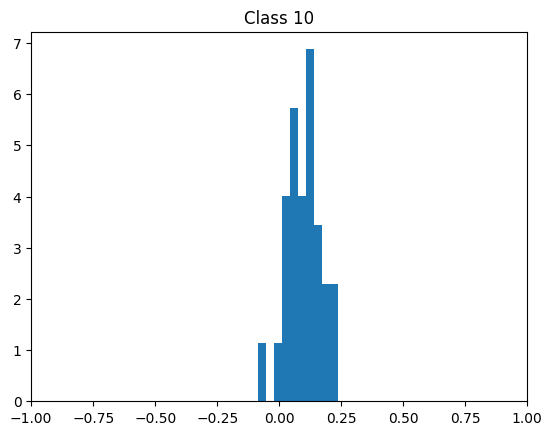

In [45]:
import math
# Plot the distributions
for c in results.keys():
    # if np.sum(np.isnan(results[c])) > 0:
    #     continue
    results[c] = [x for x in results[c] if not math.isnan(x)]
    print(results[c])
    plt.hist(results[c], bins=10, label=f"Class {c}", density=True)
    plt.xlim(-1, 1)
    plt.title(f"Class {c}")
    plt.show()

In [61]:
a = torch.rand(100, 280, 280)
a = a.view(a.size(0), -1)
print(a.shape)
# print(a.mean(dim=(1, 2)).shape)

torch.Size([100, 78400])


  0%|          | 0/1326 [00:00<?, ?it/s]

dict_values([tensor(-0.0029, dtype=torch.float64), tensor(0.1959), tensor(-0.1173), tensor(-0.0663, dtype=torch.float64), tensor(-0.2001, dtype=torch.float64), tensor(0.1248, dtype=torch.float64), tensor(-0.1349), tensor(0.7104, dtype=torch.float64), tensor(0.0787), tensor(-0.1092), tensor(0.0158, dtype=torch.float64), tensor(-0.0628), tensor(-0.1227)])
nan


C:\Users\Luca\AppData\Local\Temp\ipykernel_17400\3910621214.py:24: RuntimeWarning: invalid value encountered in log
  print(-1 * np.sum([x * np.log(x) for x in prob.values()]))


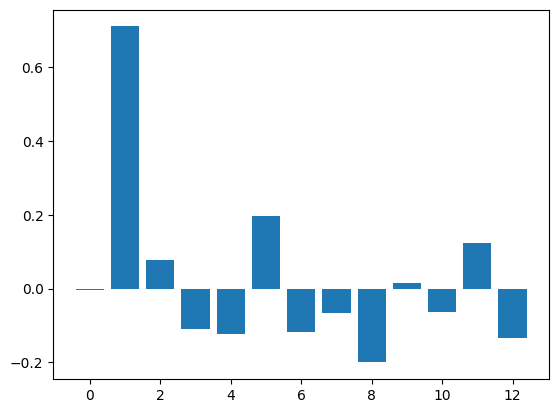

In [47]:
# For each class, print the probability distribution of the pixel belonging to that class (expected to be close to 1)
results = {}
for images, segmentations, _ in test_dl:
    images = images.to(device)
    segmentations = segmentations.to(device)
    pixel_embeddings = metric_learning_model(images)
    pixel_embeddings = pixel_embeddings.view(pixel_embeddings.size(0),pixel_embeddings.size(1), -1)
    segmentations = segmentations.view(segmentations.size(0), -1)
    
    B = len(images)
    for i in range(B):
        # print(pixel_embeddings[i].shape, pixel_embeddings[i].size(0))
        # pixel_embeddings[i] = pixel_embeddings[i].view(pixel_embeddings[i].size(0), -1)
        # Take all the pixels of class 14
        mask = segmentations[i] == 5
        masked_pixel_embeddings = pixel_embeddings[i][:, mask]
        mask_len = mask.sum()
        for j in tqdm(range(mask_len)):
            p = masked_pixel_embeddings[:, j].detach().cpu().numpy()
            prob = classify_new_pixel(p, distributions)
            print(prob.values())
            plt.bar(list(prob.keys()),list(prob.values()), label=f"Class 14")
            # Print entropy of the values
            print(-1 * np.sum([x * np.log(x) for x in prob.values()]))
            break
        break
            # for j in range(len(images[i, :, mask])):
            #     pixel_embedding = pixel_embeddings[i][:, j]
            #     print(pixel_embedding.shape)
            #     prob = probability_belong_to_class(pixel_embedding,
            #                                        distributions[c.item()]["mean"],
            #                                        np.diag(distributions[c.item()]["std"].detach().cpu().numpy()))
                
            #     if c.item() not in results:
            #         results[c.item()] = []
                
            #     results[c.item()].append(prob)
    break

In [206]:
distributions[1]["std"] * distributions[1]["mean"]

array([-0.04393528,  0.0085912 ,  0.01843853,  0.00256591, -0.03244522,
       -0.01899641,  0.02517803, -0.00844825,  0.00282314,  0.02443006,
       -0.0060989 ,  0.01634811, -0.02132743,  0.02561359, -0.02034264,
       -0.02613102, -0.02908092,  0.02375443,  0.02388554, -0.01535385,
       -0.00470139, -0.03201436,  0.00348812, -0.01007299, -0.02128236,
       -0.02600129, -0.03177002,  0.00555708, -0.03157651,  0.02028642,
       -0.0176067 , -0.00437889,  0.00943069, -0.00925851, -0.023655  ,
       -0.00093506,  0.01435583,  0.04020871,  0.03641288, -0.02589884,
       -0.00852183, -0.00106845,  0.01999136,  0.03312194,  0.01338582,
       -0.0390378 ,  0.00968643, -0.02965258, -0.05602962,  0.02961678,
       -0.02276725,  0.00691099,  0.03623429, -0.02274037, -0.00940954,
        0.0165229 ,  0.01754606,  0.03331378,  0.01798491, -0.01903442,
       -0.03662166,  0.01873045, -0.04162609,  0.05057373, -0.02934688,
        0.02174462,  0.01004412, -0.02811554, -0.0344515 ,  0.01

# TO-DO

- Insert the positive pairs selection inside the dataloader to speed up the computation.
- Change the selection of the positive pairs in order to uniformly sample from all the classes (prevents from seeing only the most prevalent classes as road, sky or vegetation)